In [1]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import os
from google.colab import drive 
import re
import zipfile
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import torch
import torch.nn as nn
import torchtext.transforms as T
import torchtext.functional as F
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/STOR566_FinalProject/')

Mounted at /content/drive


In [2]:
def txt_cleaner(string):
    string = re.sub('<[^<]+?>', '', string) #removes html
    string = re.sub(r'[^\w\s]', '', string) #removes everything but letters/numbers and whitespace
    return string.lower() #Makes all characters lowercase
    # Should we implement a method to correct mispellings too? Seems like maybe too much effort...

In [3]:
#https://github.com/neilpl24/STOR566/data/IMDB Dataset.csv.zip
#https://github.com/neilpl24/STOR566/data/Restaurant_Reviews.tsv

url_test = 'https://raw.githubusercontent.com/neilpl24/STOR566/main/data/Restaurant_Reviews.tsv'
df_test = pd.read_csv(url_test, sep = '\t')
df_test.rename(columns={'Review':'review', 'Liked':'label'}, inplace=True)
df_test["review"] = df_test["review"].apply(txt_cleaner)

In [4]:
df_test.head()

,review,label
0,wow loved this place,1
1,crust is not good,0
2,not tasty and the texture was just nasty,0
3,stopped by during the late may bank holiday of...,1
4,the selection on the menu was great and so wer...,1


In [5]:
url_train = "https://raw.githubusercontent.com/neilpl24/STOR566/main/data/IMDB_Dataset.csv"
df_train = pd.read_csv(url_train)

In [6]:
# Workaround for if Github link isn't working - put .zip file in your working google drive directory

# import zipfile

# zf = zipfile.ZipFile('IMDB Dataset.csv.zip') 
# df_train = pd.read_csv(zf.open('IMDB Dataset.csv'))

In [7]:
df_train["label"] = 1
for i in range(len(df_train)):
    if df_train.loc[i, "sentiment"] == "negative":
        df_train.loc[i, "label"] = 0
df_train.drop(columns = ["sentiment"], inplace=True)
df_train["review"] = df_train["review"].apply(txt_cleaner)

In [8]:
df_train.head()

,review,label
0,one of the other reviewers has mentioned that ...,1
1,a wonderful little production the filming tech...,1
2,i thought this was a wonderful way to spend ti...,1
3,basically theres a family where a little boy j...,0
4,petter matteis love in the time of money is a ...,1


In [9]:
class TextDataset(Dataset):
    """Text dataset."""

    def __init__(self, df, transform=None):
        """
        Args:
            df (DataFrame): dataframe to work with.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        label = self.df.iloc[idx, 1]
        review = self.df.iloc[idx, 0]
        #review = np.array([review])
        #sample = {'review': review, 'label': label}

        if self.transform:
            review = self.transform(review)

        return review, label

In [10]:
# Padding dataFrame vals to length 256 - either cutting to that length or 0-padding up to it
def padding(df, pad_len):
    '''Zero Pad tokens listed under "review" in a dataset to a pad length and return new dataset'''
    new_df = df[["label"]]
    features = []
    for i in range(len(df)):
        feature = np.zeros(pad_len, dtype=int)
        for v in range(min(pad_len, len(df.loc[i, "review"]))):
            feature[v] = df.loc[i, "review"][v]
        features.append(feature)
    new_df['review'] = [features[j] for j in new_df.index]
    return new_df

In [11]:
def yield_tokens(data_iter):
    for batch, _ in data_iter:
        yield tokenizer(batch)

td = TextDataset(df = df_train)

tokenizer = get_tokenizer('basic_english')
train_it = iter(td)

vocab_later = build_vocab_from_iterator(yield_tokens(train_it), specials=["<unk>"])
vocab_later.set_default_index(vocab_later["<unk>"])

def processing_func(train_df_orig, test_df_orig):
    train_df = train_df_orig
    test_df = test_df_orig

    train_dataset = TextDataset(df = train_df)

    tokenizer = get_tokenizer('basic_english')
    train_iter = iter(train_dataset)

    vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"])
    vocab.set_default_index(vocab["<unk>"])

    train_df["tokens"] = train_df["review"].apply(lambda x: vocab(tokenizer(x)))
    train_df.drop(["review"], axis = 1, inplace=True)
    train_df.rename(columns = {"tokens":"review"}, inplace=True)
    train_df = train_df[["review", "label"]]

    test_df["tokens"] = test_df["review"].apply(lambda x: vocab(tokenizer(x)))
    test_df.drop(["review"], axis = 1, inplace=True)
    test_df.rename(columns = {"tokens":"review"}, inplace=True)
    test_df = test_df[["review", "label"]]    

    train_df = padding(train_df, 256)
    test_df = padding(test_df, 256)

    return train_df, test_df

In [12]:
df_train_tokenized, df_test_tokenized = processing_func(df_train, df_test)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_iter = TextDataset(df = df_train_tokenized)
train_dataloader = DataLoader(train_iter, batch_size=8, shuffle=False)
test_iter = TextDataset(df_test_tokenized)
test_dataloader = DataLoader(test_iter, batch_size=8, shuffle=False)

In [ ]:
next(iter(train_dataloader))

[tensor([1, 1, 1, 0, 1, 1, 1, 0]),
 tensor([[  27,    4,    1,  ...,   19,  610,    2],
         [   3,  382,  113,  ...,    0,    0,    0],
         [   9,  191,   10,  ...,    0,    0,    0],
         ...,
         [ 233,   55, 3747,  ...,    0,    0,    0],
         [   9,  246,   56,  ...,    0,    0,    0],
         [  10,  117,   12,  ...,    0,    0,    0]])]

In [ ]:
for zero, batch in enumerate(train_dataloader):
    print(batch)
    break

[tensor([1, 1, 1, 0, 1, 1, 1, 0]), tensor([[  27,    4,    1,  ...,   19,  610,    2],
        [   3,  382,  113,  ...,    0,    0,    0],
        [   9,  191,   10,  ...,    0,    0,    0],
        ...,
        [ 233,   55, 3747,  ...,    0,    0,    0],
        [   9,  246,   56,  ...,    0,    0,    0],
        [  10,  117,   12,  ...,    0,    0,    0]])]


So as you can kind of see above, the way the batches seem to be coming out is as a list of (0, tensor), where the zero is just a placeholder (not sure why it's there) and tensor that contains 2 subtensors. If you index as "zero, batch in enumerate(dataloader)", during training, you'll get the batch in the tensor. The tensor contents are as follows:

1st sub-tensor: The labels for the batch; 1 is positive, 0 is negative.

2nd sub-tensor: A list of lists, where each list is a length-256 0-padded tokenized review that corresponds to the order of the labels.

This means that each observation can be represented as follows:

Observation i in batch:

reviews=batch[1]

labels=batch[0]

review_i = reviews[i]

label_i = labels[i]

###LSTM Implementation

In [14]:
# https://bhadreshpsavani.medium.com/tutorial-on-sentimental-analysis-using-pytorch-b1431306a2d7

train_on_gpu = torch.cuda.is_available()

class SentimentalLSTM(nn.Module):
    """
    The RNN model that will be used to perform Sentiment analysis.
    """
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):    
        """
        Initialize the model by setting up the layers
        """
        super().__init__()
        self.output_size=output_size
        self.n_layers=n_layers
        self.hidden_dim=hidden_dim
        
        #Embedding and LSTM layers
        self.embedding=nn.Embedding(vocab_size, embedding_dim)
        self.lstm=nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        
        #dropout layer
        self.dropout=nn.Dropout(0.3)
        
        #Linear and sigmoid layer
        self.fc1=nn.Linear(hidden_dim, 64)
        self.fc2=nn.Linear(64, 16)
        self.fc3=nn.Linear(16,output_size)
        self.sigmoid=nn.Sigmoid()
        
    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size=x.size()
        
        #Embadding and LSTM output
        embedd=self.embedding(x)
        lstm_out, hidden=self.lstm(embedd, hidden)
        
        #stack up the lstm output
        lstm_out=lstm_out.contiguous().view(-1, self.hidden_dim)
        
        #dropout and fully connected layers
        out=self.dropout(lstm_out)
        out=self.fc1(out)
        out=self.dropout(out)
        out=self.fc2(out)
        out=self.dropout(out)
        out=self.fc3(out)
        sig_out=self.sigmoid(out)
        
        sig_out=sig_out.view(batch_size, -1)
        sig_out=sig_out[:, -1]
        
        return sig_out, hidden
    
    def init_hidden(self, batch_size):
        """Initialize Hidden STATE"""
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        
        return hidden

In [17]:
vocab_sz = vocab_later.__len__() + 1
output_sz = 1
embed_dim = 400
h_dim = 256
n_layer = 2


lstm_mod = SentimentalLSTM(vocab_sz, output_sz, embed_dim, h_dim, n_layer)

lr = 0.001
loss_func = nn.BCELoss()
optim = torch.optim.Adam(lstm_mod.parameters(), lr=lr)
num_epochs = 10
clip=5
batch_size = 8

lstm_mod = lstm_mod.to(device)

lstm_mod.train()

epochs = []
epoch_test_losses = []
epoch_train_losses = []

'''
### Loading in epoch data for already created models
for e in range(num_epochs-2):
    print("Starting epoch #", e)
    #h = lstm_mod.init_hidden(batch_size)
    lstm_mod.load_state_dict(torch.load('lstm_mod_' + str(e+1) + '.pth'))
    epochs.append(e)
    test_outputs = []
    for zero, batch in enumerate(test_dataloader): 
        labels = batch[0].to(device)
        inputs = batch[1].to(device)
        if (len(labels) != 8):
            break
        h = tuple([each.data for each in h])
        output, h = lstm_mod(inputs, h)
        loss = loss_func(output.squeeze(), labels.float())
        test_outputs.append(float(loss))

    epoch_test_losses.append(np.mean(test_outputs))

    train_outputs = []
    for zero, batch in enumerate(train_dataloader): 
        labels = batch[0].to(device)
        inputs = batch[1].to(device)
        if (len(labels) != 8):
            break
        h = tuple([each.data for each in h])
        output, h = lstm_mod(inputs, h)
        loss = loss_func(output.squeeze(), labels.float())
        train_outputs.append(float(loss))

    epoch_train_losses.append(np.mean(train_outputs))

lstm_mod.train()
'''
#for e in [8,9]:
for e in range(num_epochs):
    print("Starting epoch #", e)
    h = lstm_mod.init_hidden(batch_size)
    counter = 0
    for zero, batch in enumerate(train_dataloader):
        labels = batch[0].to(device)
        inputs = batch[1].to(device)
        if (len(labels) != 8):
            print("Encountered shorter batch at batch #", counter)
            break #end of batchs, just leave the last few observations
        h = tuple([each.data for each in h])
        lstm_mod.zero_grad()
        output, h = lstm_mod(inputs, h)
        loss = loss_func(output.squeeze(), labels.float())
        loss.backward()
        nn.utils.clip_grad_norm_(lstm_mod.parameters(), clip)
        optim.step()
        counter += 1

    epochs.append(e)
    test_outputs = []
    for zero, batch in enumerate(test_dataloader): 
        labels = batch[0].to(device)
        inputs = batch[1].to(device)
        if (len(labels) != 8):
            break
        h = tuple([each.data for each in h])
        output, h = lstm_mod(inputs, h)
        loss = loss_func(output.squeeze(), labels.float())
        test_outputs.append(float(loss))

    epoch_test_losses.append(np.mean(test_outputs))

    train_outputs = []
    for zero, batch in enumerate(train_dataloader): 
        labels = batch[0].to(device)
        inputs = batch[1].to(device)
        if (len(labels) != 8):
            break
        h = tuple([each.data for each in h])
        output, h = lstm_mod(inputs, h)
        loss = loss_func(output.squeeze(), labels.float())
        train_outputs.append(float(loss))

    epoch_train_losses.append(np.mean(train_outputs))

    file_out_path = "lstm_mod_" + str(e+1) + ".pth"

    torch.save(lstm_mod.state_dict(), file_out_path)

Starting epoch # 0
Starting epoch # 1
Starting epoch # 2
Starting epoch # 3
Starting epoch # 4
Starting epoch # 5
Starting epoch # 6
Starting epoch # 7
Starting epoch # 8
Starting epoch # 9


In [18]:
print(lstm_mod)

SentimentalLSTM(
  (embedding): Embedding(222084, 400)
  (lstm): LSTM(400, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


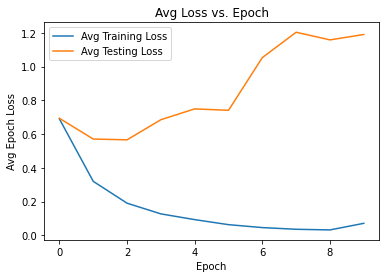

In [19]:
import matplotlib.pyplot as plt

plt.plot(epochs, epoch_train_losses, label = "Avg Training Loss")
plt.plot(epochs, epoch_test_losses, label = "Avg Testing Loss")
plt.xlabel("Epoch")
plt.ylabel("Avg Epoch Loss")
plt.title("Avg Loss vs. Epoch")
plt.legend()
plt.show()

In [20]:
outputs = []
for zero, batch in enumerate(test_dataloader): 
    labels = batch[0].to(device)
    inputs = batch[1].to(device)
    h = tuple([each.data for each in h])
    output, h = lstm_mod(inputs, h)
    output = output > 0.5
    accurate = output == labels
    for elem in accurate:
        outputs.append(bool(elem))

print("Final testing accuracy of the model: ", np.mean(outputs))

Final testing accuracy of the model:  0.711


In [21]:
outputs = []
for zero, batch in enumerate(train_dataloader): 
    labels = batch[0].to(device)
    inputs = batch[1].to(device)
    h = tuple([each.data for each in h])
    output, h = lstm_mod(inputs, h)
    output = output > 0.5
    accurate = output == labels
    for elem in accurate:
        outputs.append(bool(elem))

print("Final training accuracy of the model: ", np.mean(outputs))

Final training accuracy of the model:  0.98028


In [ ]:

os.chdir('/content/drive/MyDrive/STOR566_FinalProject/')

torch.save(lstm_mod.state_dict(), 'lstm_mod.pth')

In [ ]:
vocab_sz = vocab_later.__len__() + 1
output_sz = 1
embed_dim = 400
h_dim = 256
n_layer = 2


mod = SentimentalLSTM(vocab_sz, output_sz, embed_dim, h_dim, n_layer)

mod.load_state_dict(torch.load('lstm_mod.pth'))